In [1]:
import numpy as np
import pandas as pd
import psutil
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from tensorflow import keras
from sklearn.metrics import matthews_corrcoef, accuracy_score, root_mean_squared_error, mean_squared_error, mean_absolute_error, precision_score, confusion_matrix, multilabel_confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm
import time
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import gc
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import pickle

2025-05-13 17:57:20.977845: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747148240.999322  133587 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747148241.005399  133587 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747148241.021821  133587 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747148241.021856  133587 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747148241.021858  133587 computation_placer.cc:177] computation placer alr

# Functions

In [2]:
data_30000 = {}

In [3]:
def visualize_CM(matrix):
    """
    Visualize Correlation Matrix
    """
    sns.heatmap(matrix,annot=True)

def result_plot(_dict, name, folder, model_name):
    """
    Plot results for multiclass classification
    """
    with open('results_30000_mc.txt', 'a') as file:
        file.write(f"{name}: {_dict}")
    attacks = {}
    higher = ["F1", "Accuracy", "Precision", "Recall", "MCC", "precision", "recall", "f1-score", "support", 'Benign', 'Bruteforce', 'DDoS', 'DoS', 'Mirai', 'Recon', 'Spoofing',
       'Web']
    fig, ax = plt.subplots(figsize=(10,10))
    if name in higher:
        tmp = sorted(_dict.items(), key = lambda x:x[1])
    else:
        tmp = sorted(_dict.items(), key = lambda x:x[1], reverse=True)
    for x in tmp:
        attacks[x[0]] = x[1]
    ax.bar(attacks.keys(), attacks.values())
    rects = ax.patches
    results = [i for i in attacks.values()]
    labels = [f"{results[i]:.6f}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom"
        )
    if name in higher:
        name = name.capitalize()
        ax.set_title(f'{name} (higher is better)', fontsize=16, fontweight="bold")
    else:
        ax.set_title(f'{name} (lower is better)', fontsize=16, fontweight="bold")
    ax.set_xlabel(f'{name}')
    ax.set_ylabel('Score')
    ax.grid(which='Major', axis='both')
    ax.set_axisbelow(True)
    if (model_name == ""):
        plt.savefig(f"images/results/{folder}/30000/{name}.png")
    else:
        plt.savefig(f"images/results/{folder}/30000/{name}_{model_name}.png")

def plot_mc(y_pred, y_test, model_name, mc_results = {}):
    """
    Plots Precision, Recall and F1 scores for each class in multiclass classification
    """
    cr = classification_report(y_pred, y_test, output_dict=True)
    for key, name in cr.items():
        if key not in ['accuracy', 'macro avg', 'weighted avg'] and int(key) in attack_dict:
            mc_results[attack_dict[int(key)]] = cr[key]
    mc_results = pd.DataFrame(mc_results).drop(['support'], axis = 0)
    for key in mc_results.keys():
        data_30000[key] = mc_results[key].to_dict()
    x = pd.DataFrame(data_30000).transpose().to_dict()
    with open('results_30000_precision.txt', 'a') as f:
        f.write(f"{model_name}: {x['precision']}")
    with open('results_30000_recall.txt', 'a') as f:
        f.write(f"{model_name}: {x['recall']}")
    with open('results_30000_f1.txt', 'a') as f:
        f.write(f"{model_name}: {x['f1-score']}")
    for key in mc_results.keys():
        result_plot(mc_results[key], key, "multiclass_by_class", model_name)

def measure_latency_cpu_usage(model, test_inputs):
    process = psutil.Process()
    cpu_start = process.cpu_percent()
    start = time.time()
    predictions = model.predict(test_inputs)
    end = time.time()
    cpu_end = process.cpu_percent()
    latency = end - start
    cpu_usage = cpu_end - cpu_start
    return latency, cpu_usage

# Load data

In [4]:
data = pd.read_csv('data/CIC_IoT2023/custom/multiclass_classification_data_30000.csv')

In [5]:
data = data.drop(['Unnamed: 0', 'label', 'Class'], axis=1)

In [6]:
data.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Attack Type
0,0.0,0.0,0.99,65.27,1.232415,1.232415,0.0,0.0,0.0,0.0,...,0.617394,42.18,8.312856e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55,DDoS
1,0.0,54.0,6.00,64.00,31.840037,31.840037,0.0,0.0,1.0,0.0,...,0.000000,54.00,8.309343e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS
2,0.0,0.0,0.99,63.36,2.481472,2.481472,0.0,0.0,0.0,0.0,...,0.617394,42.18,8.314964e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55,DDoS
3,0.0,54.0,6.00,64.00,4.499163,4.499163,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.333215e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS
4,0.0,54.0,6.00,64.00,15.849033,15.849033,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.307156e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS


In [7]:
data.tail()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Attack Type
217888,3066.037345,10267.5,11.5,130.5,1.029689,1.029689,0.0,0.0,0.0,0.0,...,48.073719,175.9,4.020541e-02,5.5,15.420603,67.986505,3619.117272,0.9,38.5,Bruteforce
217889,343.000496,106722.4,12.6,96.3,3.483237,3.483237,0.0,0.0,0.0,0.0,...,53.837593,81.8,1.666014e+08,13.5,13.133269,76.311509,2921.188688,1.0,244.6,Bruteforce
217890,199.262425,16583.6,9.3,118.9,0.319272,0.319272,0.0,0.0,0.0,0.0,...,71.998962,101.7,2.843370e-02,5.5,14.011221,101.821908,7002.672673,0.9,38.5,Bruteforce
217891,177.979327,29709.7,9.3,93.8,1.760932,1.760932,0.0,0.0,0.0,0.0,...,66.139131,94.8,1.666014e+08,13.5,14.883212,93.714094,4411.596919,1.0,244.6,Bruteforce
217892,299.487685,38503.2,15.3,57.6,2.423920,2.423920,0.0,0.0,0.0,0.0,...,77.932213,137.4,1.224859e-02,5.5,14.286196,110.212793,9866.644535,0.9,38.5,Bruteforce


In [8]:
X = data.drop(['Attack Type'], axis = 1)
y = data['Attack Type']

In [9]:
X.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight
0,0.0,0.0,0.99,65.27,1.232415,1.232415,0.0,0.0,0.0,0.0,...,42.180879,0.617394,42.18,8.312856e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55
1,0.0,54.0,6.00,64.00,31.840037,31.840037,0.0,0.0,1.0,0.0,...,54.000000,0.000000,54.00,8.309343e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55
2,0.0,0.0,0.99,63.36,2.481472,2.481472,0.0,0.0,0.0,0.0,...,42.180879,0.617394,42.18,8.314964e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55
3,0.0,54.0,6.00,64.00,4.499163,4.499163,0.0,0.0,0.0,0.0,...,54.000000,0.000000,54.00,8.333215e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55
4,0.0,54.0,6.00,64.00,15.849033,15.849033,0.0,0.0,0.0,0.0,...,54.000000,0.000000,54.00,8.307156e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55


In [10]:
y

0               DDoS
1               DDoS
2               DDoS
3               DDoS
4               DDoS
             ...    
217888    Bruteforce
217889    Bruteforce
217890    Bruteforce
217891    Bruteforce
217892    Bruteforce
Name: Attack Type, Length: 217893, dtype: object

In [11]:
le = LabelEncoder()

data['Attack Number'] = le.fit_transform(y)
y = data['Attack Number']

In [12]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [13]:
attack_dict = {}
encoded_values = data['Attack Number'].unique()
for val in sorted(encoded_values):
    attack_dict[val] = le.inverse_transform([val])[0]
    print(f"{val}: {le.inverse_transform([val])[0]}")

0: Benign
1: Bruteforce
2: DDoS
3: DoS
4: Mirai
5: Recon
6: Spoofing
7: Web


# Multiclass Classification

In [14]:
results_dict = {}

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((185209, 46), (185209,), (32684, 46), (32684,))

In [16]:
# Unique train values
unique, counts = np.unique(y_train, return_counts=True)
for x, y in zip(unique, counts):
    print(f"{x}: {y}")

0: 25601
1: 11077
2: 25520
3: 25463
4: 25493
5: 25543
6: 25393
7: 21119


In [17]:
# Unique train values
unique, counts = np.unique(y_test, return_counts=True)
for x, y in zip(unique, counts):
    print(f"{x}: {y}")

0: 4399
1: 1987
2: 4480
3: 4537
4: 4507
5: 4457
6: 4607
7: 3710


# K Nearest Neighbour

In [ ]:
%%time

start = time.time()

knn_clf = KNeighborsClassifier(n_jobs=8)
knn_clf.fit(X_train, y_train)

y_pred = knn_clf.predict(X_test)

end = time.time()

KNN_time = end - start

In [ ]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [ ]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [ ]:
latency, cpu_usage = measure_latency_cpu_usage(knn_clf, X_test)

In [ ]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, latency, KNN_time]
results_dict["kNN"] = results

results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Latency (ms)", "Time"])

In [ ]:
results_df

In [ ]:
plot_mc(y_pred, y_test, "kNN")

In [ ]:
model_name = "kNN_30000.sav"
pickle.dump(knn_clf, open(model_name, 'wb'))

# Naive Bayes

In [18]:
%%time

start_time = time.perf_counter()

nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)

y_pred = nb_clf.predict(X_test)

end_time = time.perf_counter()

NB_time = end_time - start_time

CPU times: user 186 ms, sys: 34.5 ms, total: 220 ms
Wall time: 223 ms


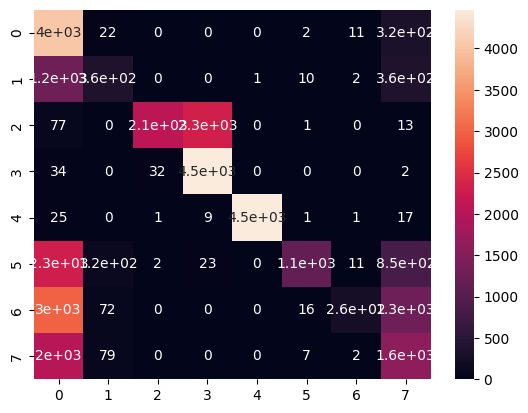

In [19]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [20]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)
latency, cpu_usage = measure_latency_cpu_usage(nb_clf, X_test)

In [21]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, latency, NB_time]
results_dict["NB"] = results

results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Latency (ms)", "Time"])

In [22]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Latency (ms),Time
NB,0.563579,0.740764,0.527999,0.563579,0.530456,1.731673,9.481887,3.079267,0.079532,0.222761


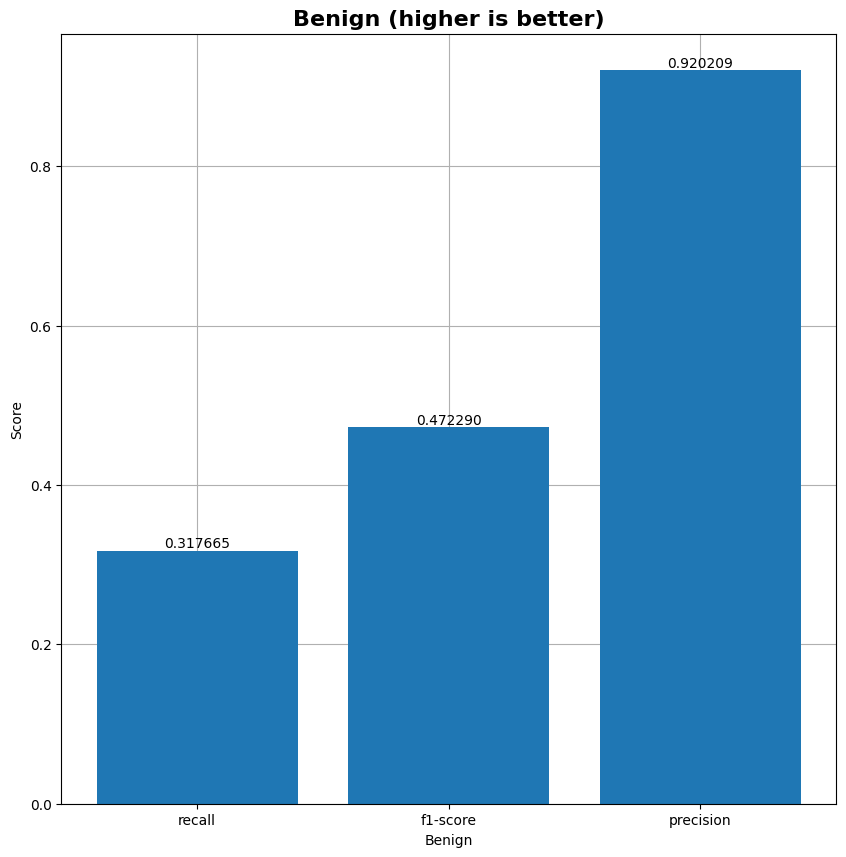

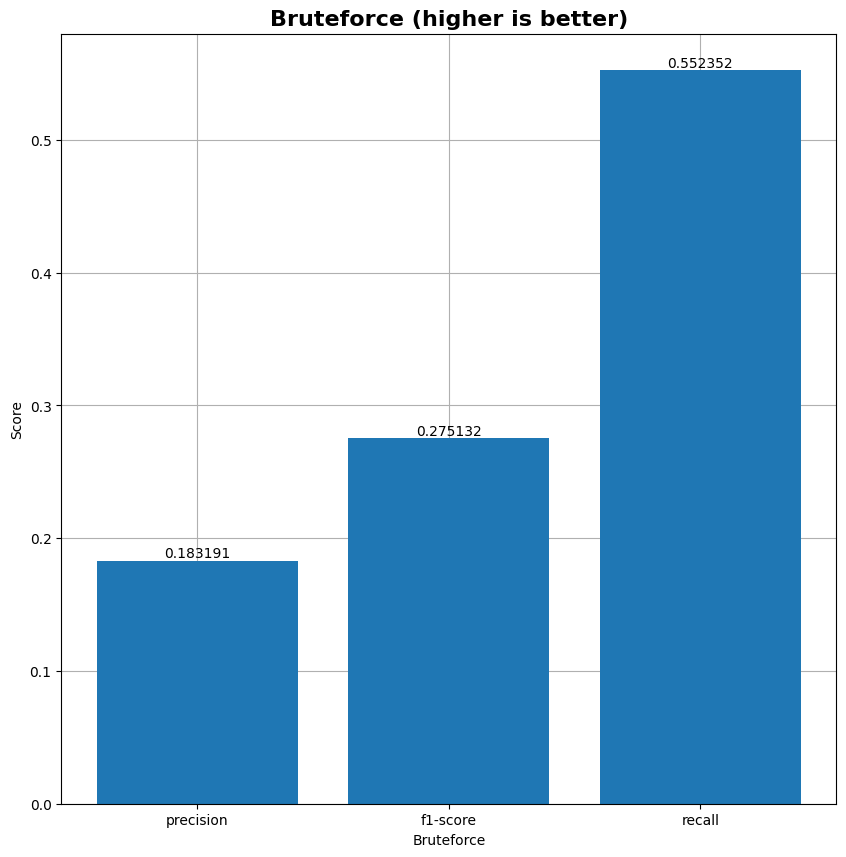

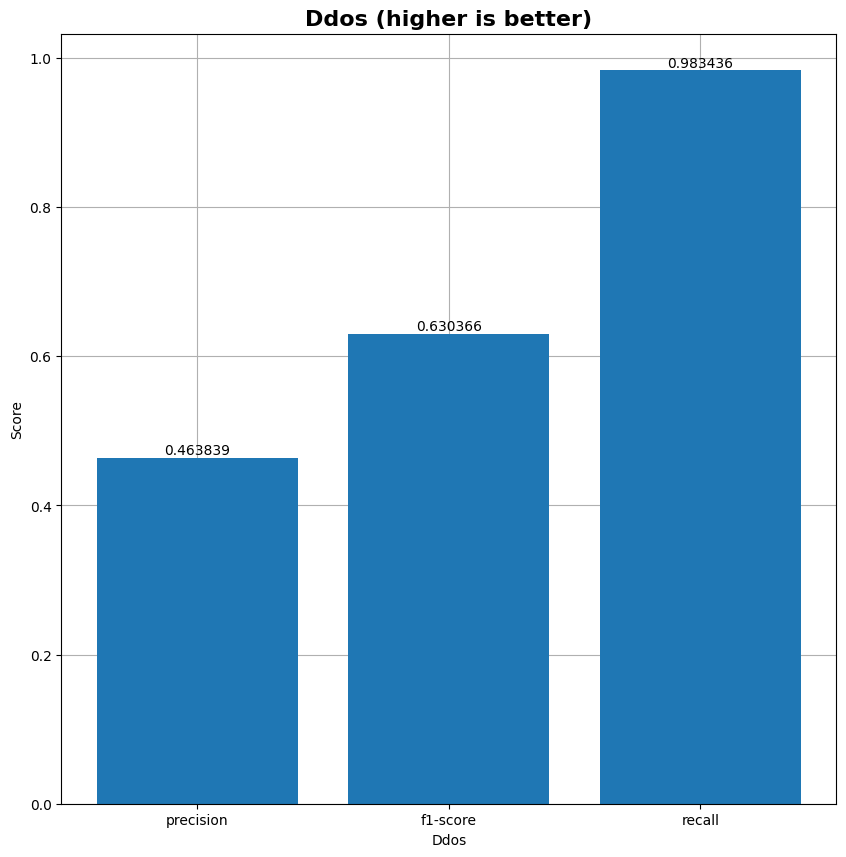

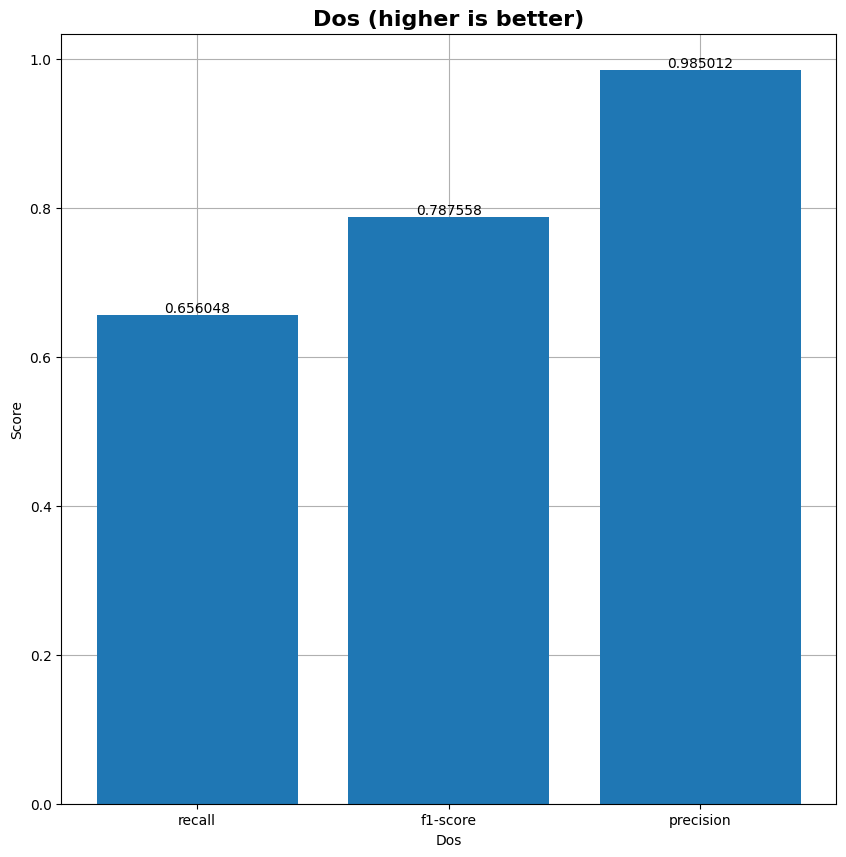

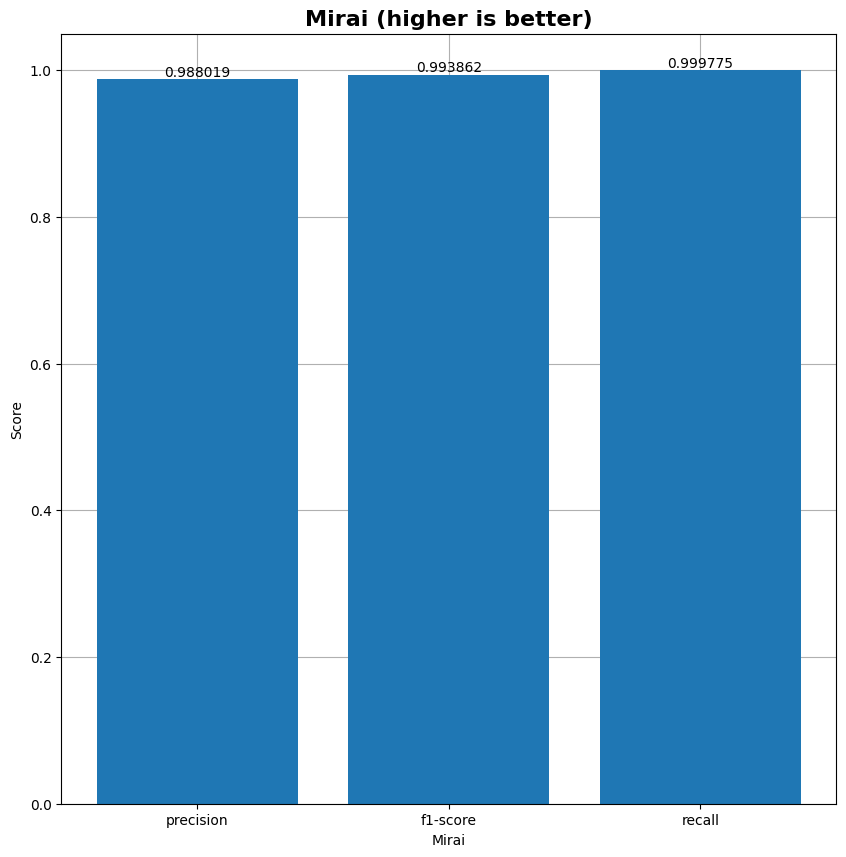

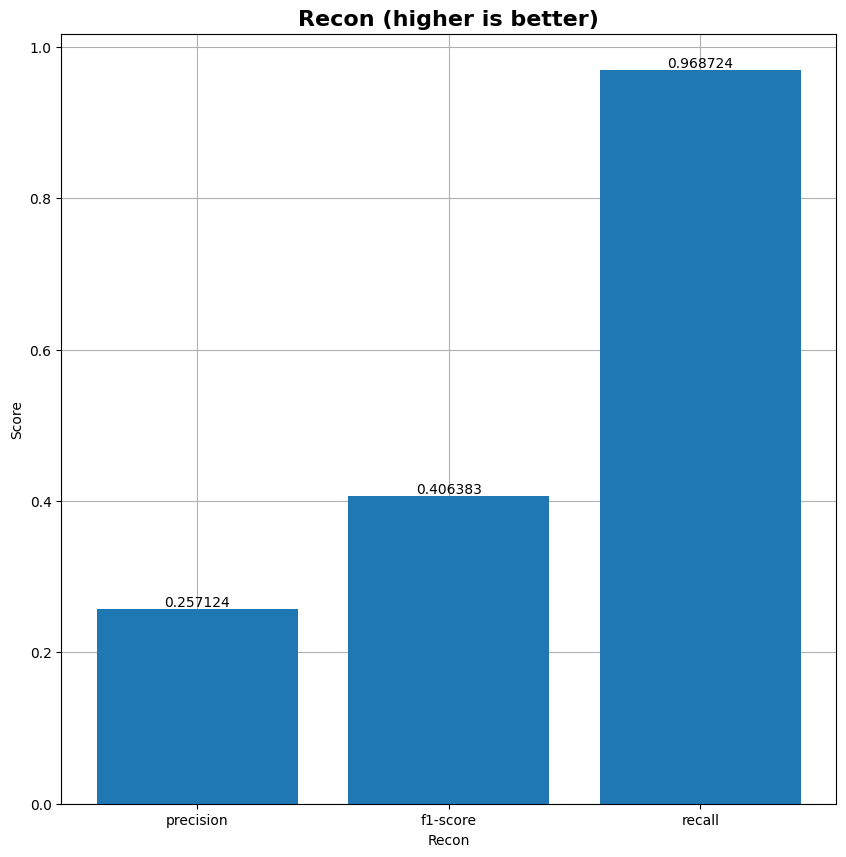

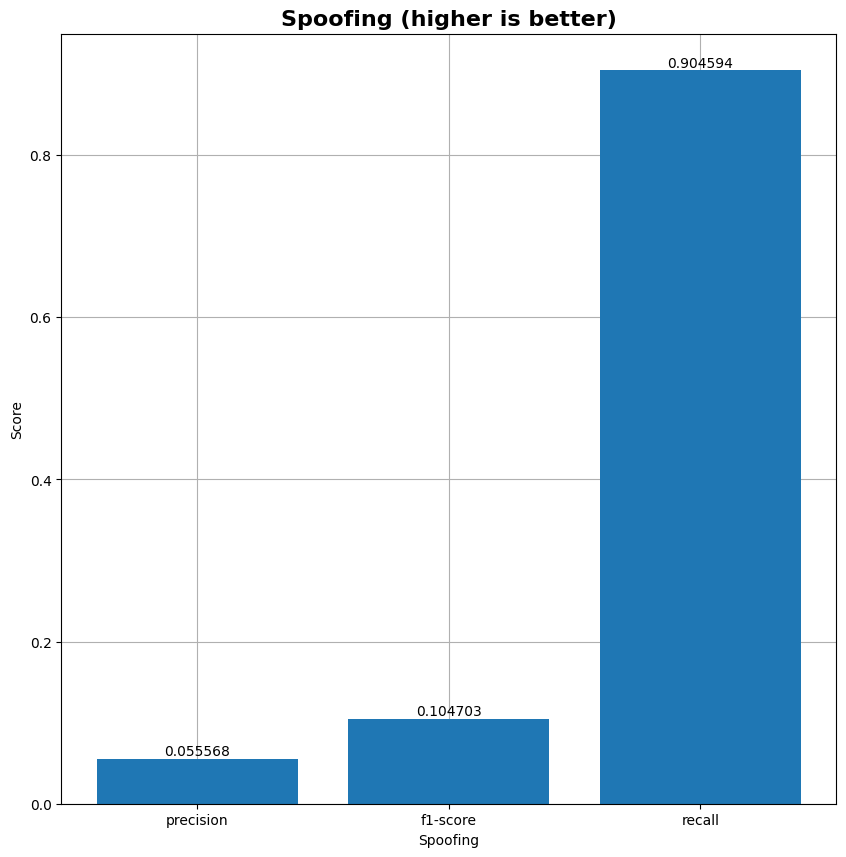

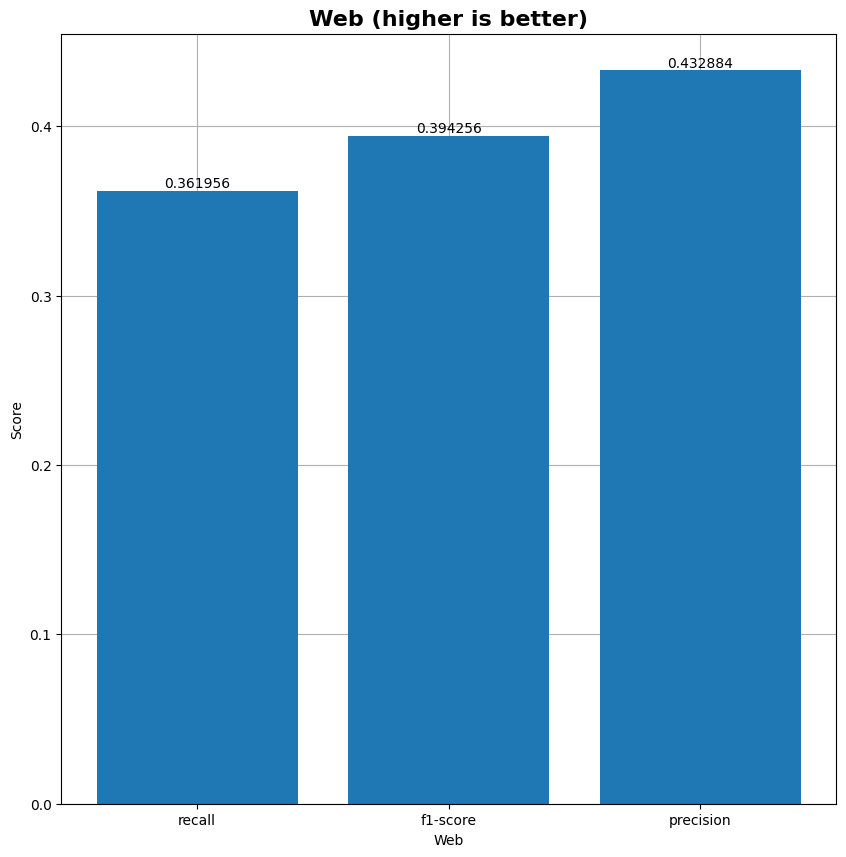

In [23]:
plot_mc(y_pred, y_test, "NB")

In [24]:
model_name = "NB_30000.sav"
pickle.dump(nb_clf, open(model_name, 'wb'))

# Logistic Regression

In [ ]:
%%time

start = time.time()

lr_clf = LogisticRegression(max_iter = 10000, C = 0.1, random_state = 0, solver = 'saga', n_jobs=8)
lr_clf.fit(X_train, y_train)

y_pred = lr_clf.predict(X_test)

end = time.time()

LR_time = end - start

In [ ]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [ ]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [ ]:
latency, cpu_usage = measure_latency_cpu_usage(lr_clf, X_test)

In [ ]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, latency, LR_time]
results_dict["LR"] = results

results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Latency (ms)", "Time"])

In [ ]:
results_df

In [ ]:
plot_mc(y_pred, y_test, "LR")

In [ ]:
model_name = "LR_30000.sav"
pickle.dump(lr_clf, open(model_name, 'wb'))

# Random Forest

In [ ]:
%%time

start = time.time()

rf_clf = RandomForestClassifier(n_jobs=8)
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)

end = time.time()

RF_time = end - start

In [ ]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [ ]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [ ]:
latency, cpu_usage = measure_latency_cpu_usage(rf_clf, X_test)

In [ ]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, latency, RF_time]
results_dict["RF"] = results

results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Latency (ms)", "Time"])

In [ ]:
results_df

In [ ]:
plot_mc(y_pred, y_test, "RF")

In [ ]:
model_name = "RF_30000.sav"
pickle.dump(rf_clf, open(model_name, 'wb'))

# XGBoost

In [ ]:
%%time

start = time.time()

xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)

y_pred = xgb_clf.predict(X_test)

end = time.time()

XGB_time = end - start

In [ ]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [ ]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [ ]:
latency, cpu_usage = measure_latency_cpu_usage(xgb_clf, X_test)

In [ ]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, latency, XGB_time]
results_dict["XGBoost"] = results

results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Latency (ms)", "Time"])

In [ ]:
results_df

In [ ]:
plot_mc(y_pred, y_test, "XGBoost")

In [ ]:
model_name = "XGB_30000.sav"
pickle.dump(xgb_clf, open(model_name, 'wb'))

# LightGBM

In [ ]:
%%time

start = time.time()

lgbm_clf = lightgbm.LGBMClassifier()
lgbm_clf.fit(X_train, y_train)

y_pred = lgbm_clf.predict(X_test)

end = time.time()

LightGBM_Time = end - start

In [ ]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [ ]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [ ]:
latency, cpu_usage = measure_latency_cpu_usage(lgbm_clf, X_test)

In [ ]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, latency, LightGBM_Time]
results_dict["LightGBM"] = results

results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Latency (ms)", "Time"])

In [ ]:
results_df

In [ ]:
plot_mc(y_pred, y_test, "LightGBM")

In [ ]:
model_name = "LightGBM_30000.sav"
pickle.dump(lgbm_clf, open(model_name, 'wb'))

# CatBoost

In [25]:
%%time

start_time = time.perf_counter()

cb_clf = CatBoostClassifier(silent = True)
cb_clf.fit(X_train, y_train)

y_pred = cb_clf.predict(X_test)

end_time = time.perf_counter()

CatBoost_Time = end_time - start_time

CPU times: user 8min 47s, sys: 1min 2s, total: 9min 50s
Wall time: 1min 42s


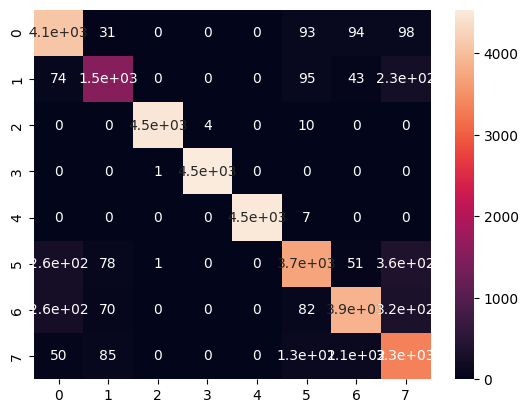

In [26]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [27]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [28]:
latency, cpu_usage = measure_latency_cpu_usage(cb_clf, X_test)

In [29]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, latency, CatBoost_Time]
results_dict["CatBoost"] = results

results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Latency (ms)", "Time"])

In [30]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Latency (ms),Time
NB,0.563579,0.740764,0.527999,0.563579,0.530456,1.731673,9.481887,3.079267,0.079532,0.222761
CatBoost,0.918798,0.921948,0.919008,0.918798,0.907071,0.301126,1.496451,1.223295,0.507095,102.016905


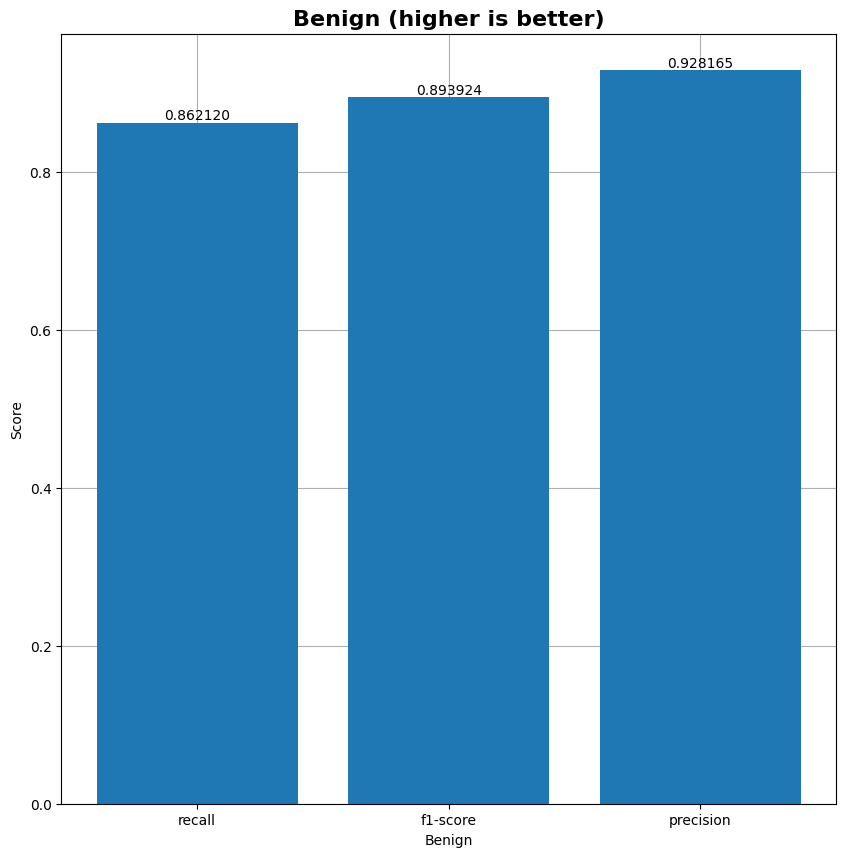

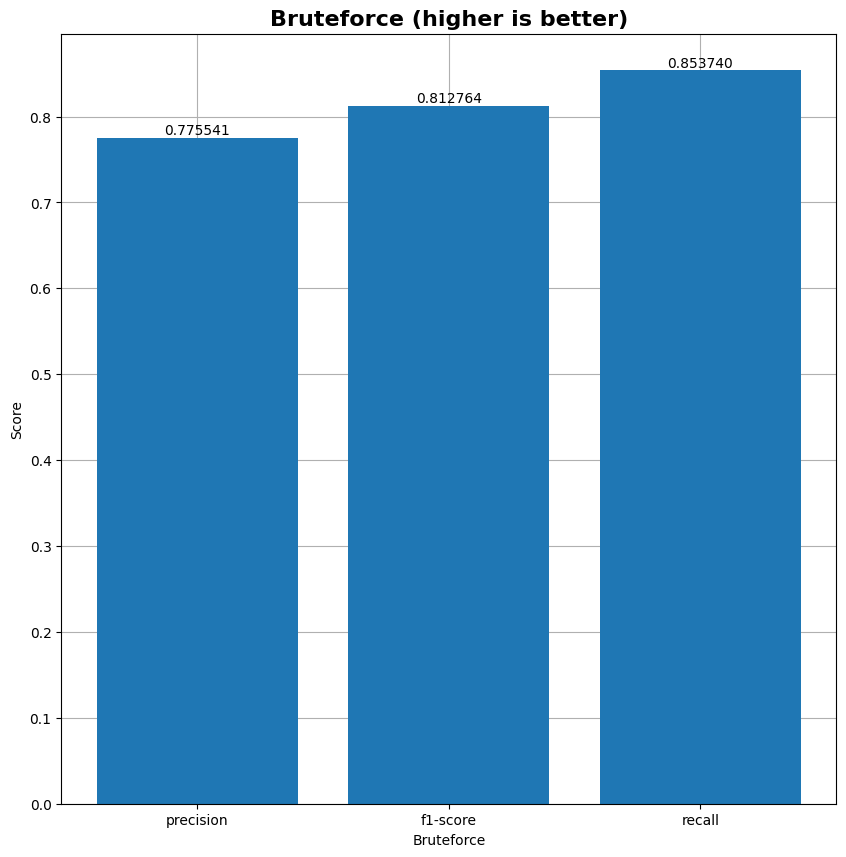

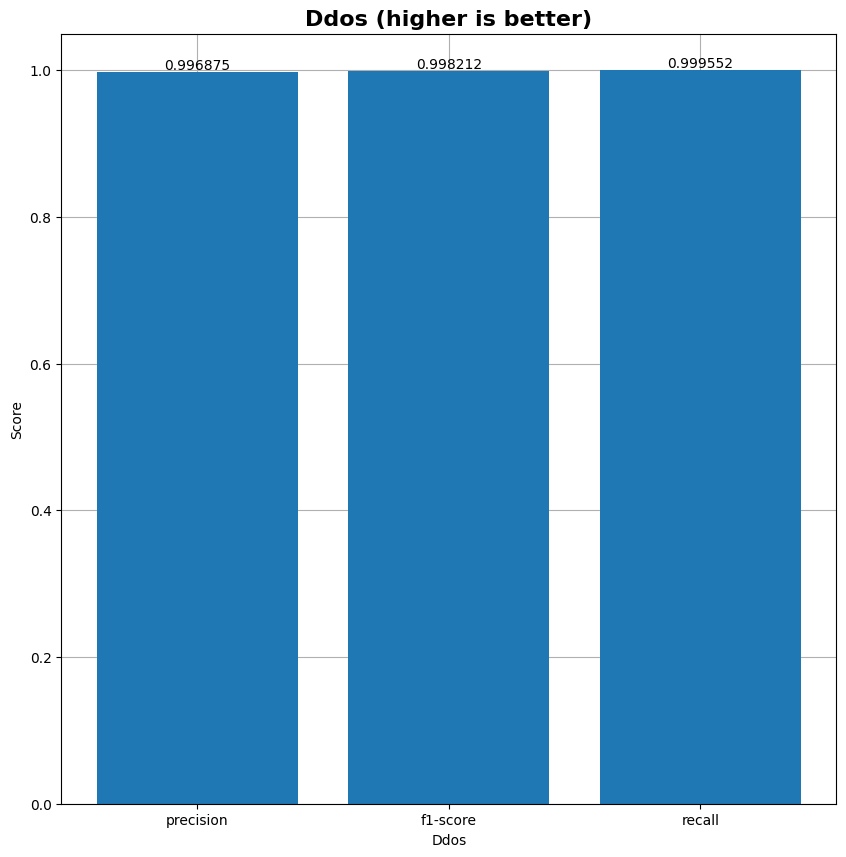

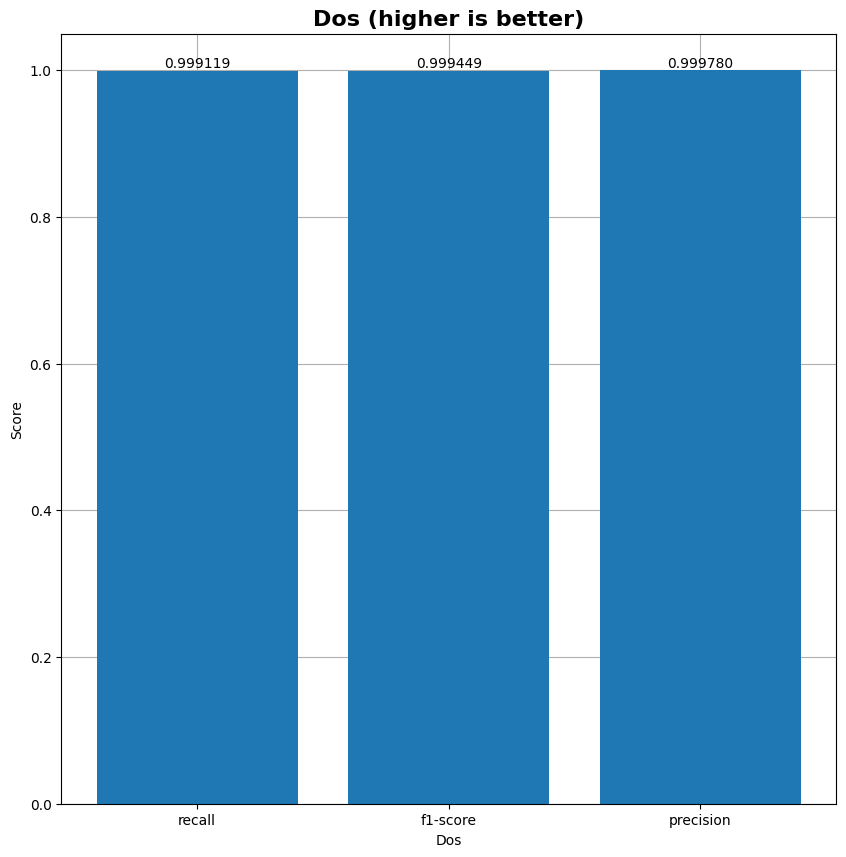

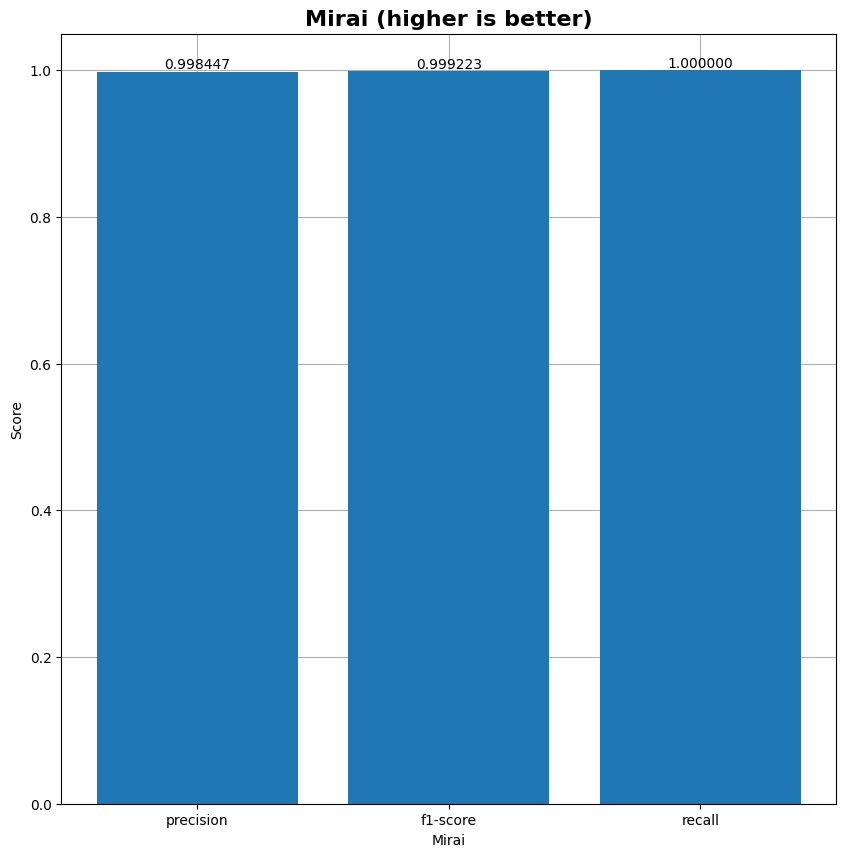

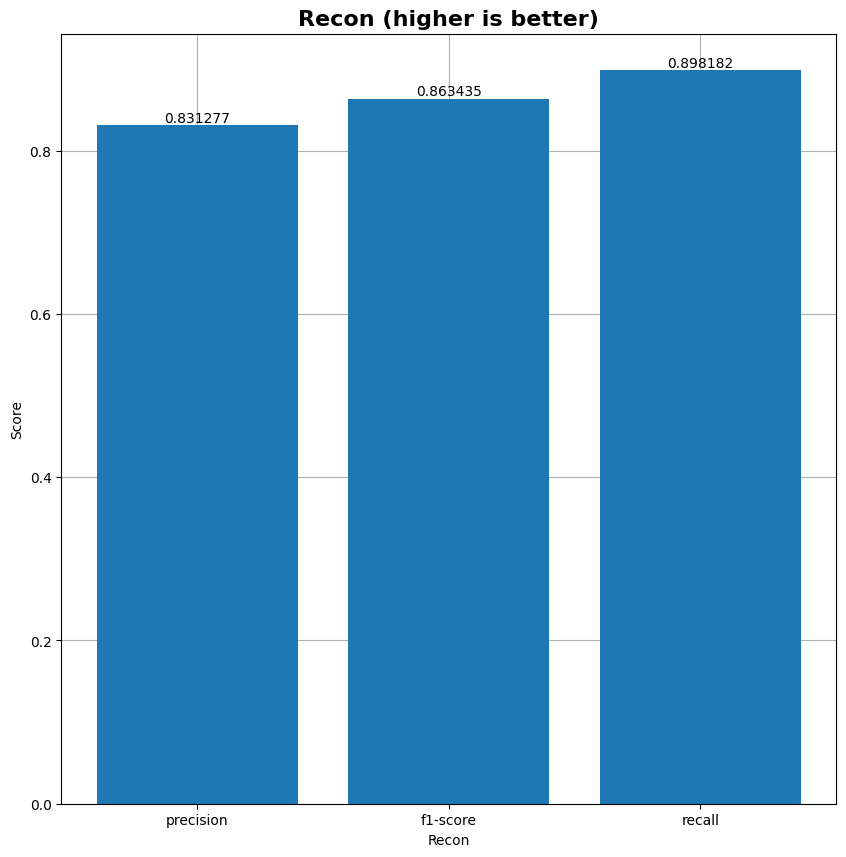

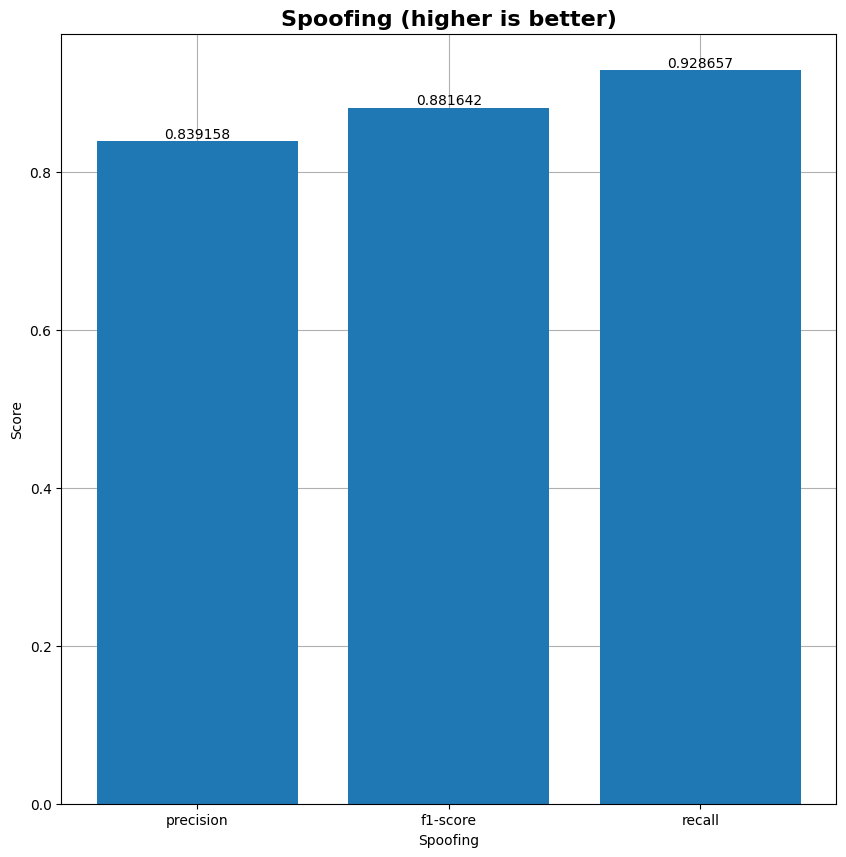

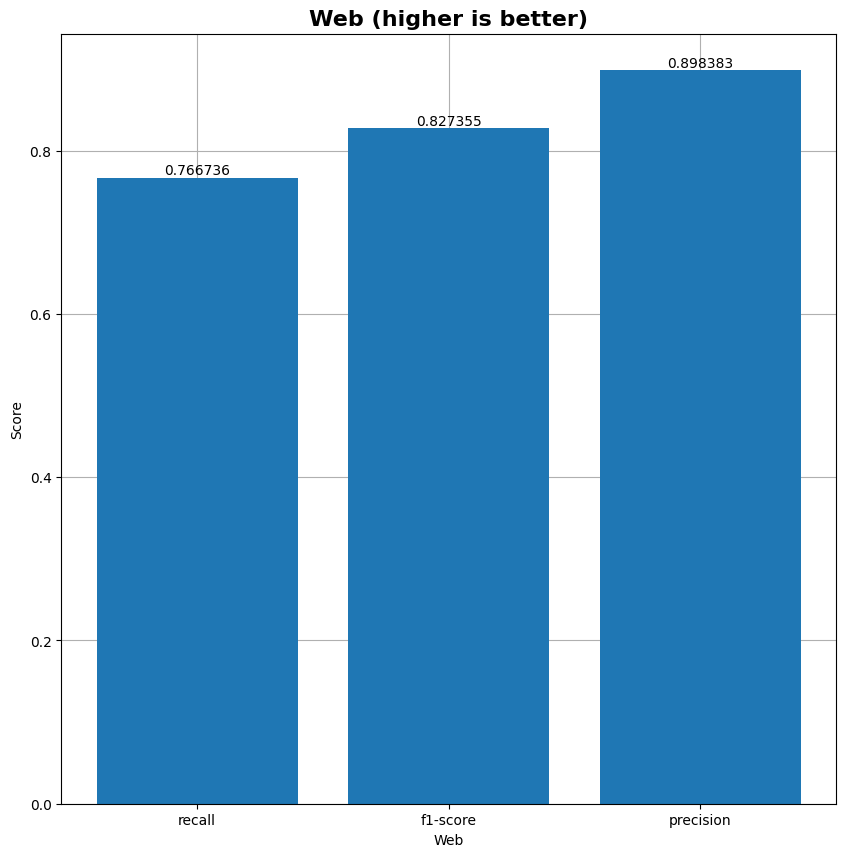

In [31]:
plot_mc(y_pred, y_test, "Catboost")

In [33]:
model_name = "CatBoost_30000.sav"
pickle.dump(cb_clf, open(model_name, 'wb'))

# Support Vector Machine

In [ ]:
%%time

start = time.time()

svm_clf = SVC(kernel = 'poly', C = 1, random_state = 0, probability = True)
svm_clf.fit(X_train, y_train)

y_pred = svm_clf.predict(X_test)

end = time.time()

SVM_Time = end - start

In [ ]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [ ]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [ ]:
latency, cpu_usage = measure_latency_cpu_usage(svm_clf, X_test)

In [ ]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, latency, SVM_Time]
results_dict["SVM"] = results

results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Latency (ms)", "Time"])

In [ ]:
results_df

In [ ]:
plot_mc(y_pred, y_test, "SVM")

In [ ]:
model_name = "SVM_30000.sav"
pickle.dump(svm_clf, open(model_name, 'wb'))

# Feed Forward Neural Network

In [ ]:
X = data.drop(['Attack Type'], axis = 1)
y = data['Attack Type']

data['Attack Number'] = le.fit_transform(y)
y = data['Attack Number']

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

In [ ]:
def create_model(X_train, y_train):
    model = keras.Sequential()
    model.add(keras.layers.Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)))
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dense(len(np.unique(y_train)), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
model = create_model(X_train, y_train)

In [ ]:
model.summary()

In [ ]:
%%time

start = time.time()

model.fit(X_train, y_train,
          batch_size=16,
          epochs=20,
          validation_data=(X_val, y_val))
gc.collect();

y_pred = model.predict(X_test)

end = time.time()

FFNN_Time = end - start

In [ ]:
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
_, accuracy = model.evaluate(X_test, y_test)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [ ]:
latency, cpu_usage = measure_latency_cpu_usage(model, X_test)

In [ ]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, latency, FFNN_Time]
results_dict["FF-NN"] = results

results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Latency (ms)", "Time"])

In [ ]:
results_df

In [ ]:
plot_mc(y_pred, y_test, "FF-NN")

In [ ]:
model_name = "FFNN_30000.sav"
pickle.dump(model, open(model_name, 'wb'))

# Create sequences

Create sequences for LSTM and GRU RNN variants

In [34]:
X = data.drop(['Attack Type'], axis = 1)
y = data['Attack Type']

y = data['Attack Number']

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [35]:
# Prepare sequential data
def create_sequences(features, labels, seq_length):
    sequences, seq_labels = [], []
    for i in range(len(features) - seq_length):
        sequences.append(features[i:i + seq_length])
        seq_labels.append(labels[i + seq_length - 1])  # Use the last label in the sequence
    return np.array(sequences), np.array(seq_labels)

In [36]:
num_components = len(np.unique(y))

In [37]:
# Create sequences
seq_length = 20
X1, y1 = create_sequences(X, y, seq_length)
y1 = to_categorical(y1, num_classes=num_components)  # Convert labels to one-hot encoding

# LSTM

In [ ]:
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X1, y1, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
def create_model_LSTM(input_shape, num_classes):
    model = keras.Sequential([
        keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True),
        keras.layers.Dropout(0.3),
        keras.layers.LSTM(32),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')  # Use softmax for multi-class classification
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Build model
model = create_model_LSTM(input_shape=(seq_length, X1.shape[2]), num_classes=num_components)

In [ ]:
model.summary()

In [ ]:
%%time

start = time.time()

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

# Evaluate model
y_pred = model.predict(X_test)

end = time.time()

LSTM_Time = end - start

In [ ]:
_, accuracy = model.evaluate(X_test, y_test)

In [ ]:
latency, cpu_usage = measure_latency_cpu_usage(model, X_test)

In [ ]:
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [ ]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, latency, LSTM_Time]
results_dict["LSTM"] = results

results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Latency (ms)", "Time"])

In [ ]:
results_df

In [ ]:
plot_mc(y_pred, y_test, "LSTM")

In [ ]:
model_name = "LSTM_30000.sav"
pickle.dump(model, open(model_name, 'wb'))

# GRU

In [38]:
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X1, y1, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [39]:
def create_model_GRU(input_shape, num_classes):
    model = keras.Sequential([
        keras.layers.GRU(64, input_shape=input_shape, return_sequences=True),
        keras.layers.Dropout(0.3),
        keras.layers.GRU(32),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(num_classes, activation='sigmoid')  # Use softmax for multi-class classification
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [40]:
# Build model
model = create_model_GRU(input_shape=(seq_length, X1.shape[2]), num_classes=num_components)

I0000 00:00:1747148496.652163  133587 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5080 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1
/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [41]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 20, 64)         │        21,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,736 (131.78 KB)

 Trainable params: 33,736 (131.78 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
%%time

start = time.time()

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

# Evaluate model
y_pred = model.predict(X_test)

end = time.time()

GRU_Time = end - start

Epoch 1/10


I0000 00:00:1747148500.446258  146978 cuda_dnn.cc:529] Loaded cuDNN version 90300


4766/4766 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - accuracy: 0.9719 - loss: 0.1086 - val_accuracy: 0.9944 - val_loss: 0.0248
Epoch 2/10
4766/4766 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - accuracy: 0.9994 - loss: 0.0030 - val_accuracy: 1.0000 - val_loss: 8.5626e-05
Epoch 3/10
4766/4766 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - accuracy: 0.9998 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 1.3863e-04
Epoch 4/10
4766/4766 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - accuracy: 0.9998 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 2.3686e-04
Epoch 5/10
4766/4766 ━━━━━━━━━━━━━━━━━━━━ 35s 7ms/step - accuracy: 0.9998 - loss: 9.2701e-04 - val_accuracy: 1.0000 - val_loss: 2.2630e-06
Epoch 6/10
4766/4766 ━━━━━━━━━━━━━━━━━━━━ 35s 7ms/step - accuracy: 0.9998 - loss: 9.6225e-04 - val_accuracy: 1.0000 - val_loss: 1.0754e-05
Epoch 7/10
4766/4766 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step - accuracy: 0.9998 - loss: 8.0187e-04 - val_accuracy: 0.9999 - val_loss: 4.2467e-04
Epoch 8/10
4766/4766 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - a

In [43]:
_, accuracy = model.evaluate(X_test, y_test)

1022/1022 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9999 - loss: 1.2625e-04


In [44]:
latency, cpu_usage = measure_latency_cpu_usage(model, X_test)

1022/1022 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [45]:
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

In [46]:
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [47]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, latency, GRU_Time]
results_dict["GRU"] = results

results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Latency (ms)", "Time"])

In [48]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Latency (ms),Time
NB,0.563579,0.740764,0.527999,0.563579,0.530456,1.731673,9.481887,3.079267,0.079532,0.222761
CatBoost,0.918798,0.921948,0.919008,0.918798,0.907071,0.301126,1.496451,1.223295,0.507095,102.016905
GRU,0.999847,0.999847,0.999847,0.999847,0.999824,0.000153,0.000153,0.012369,2.562508,359.035024


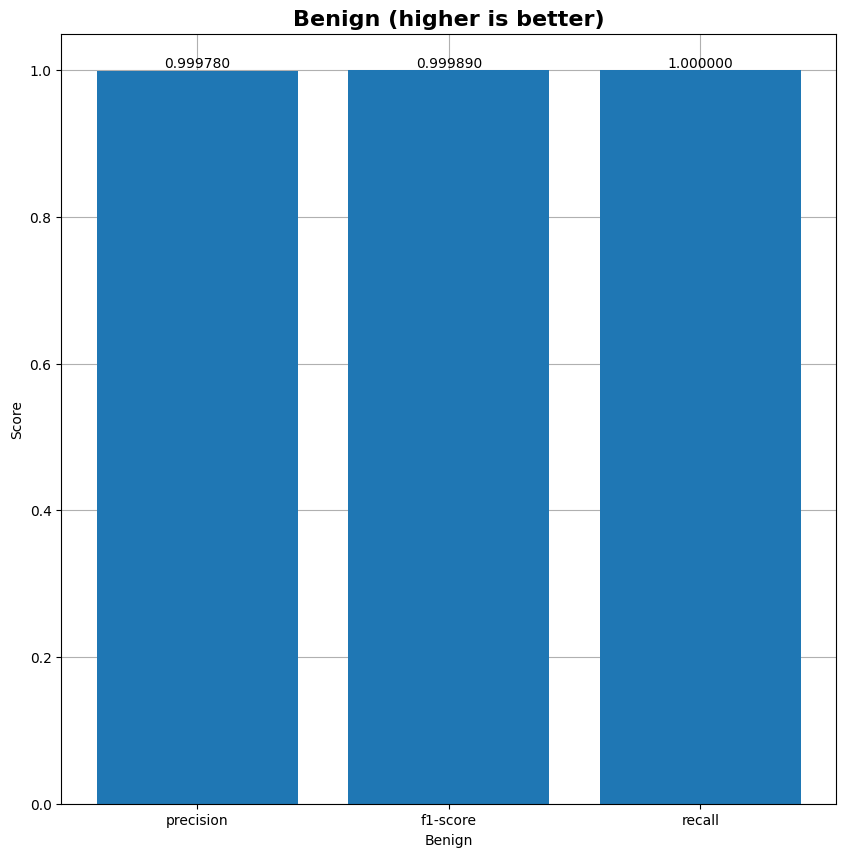

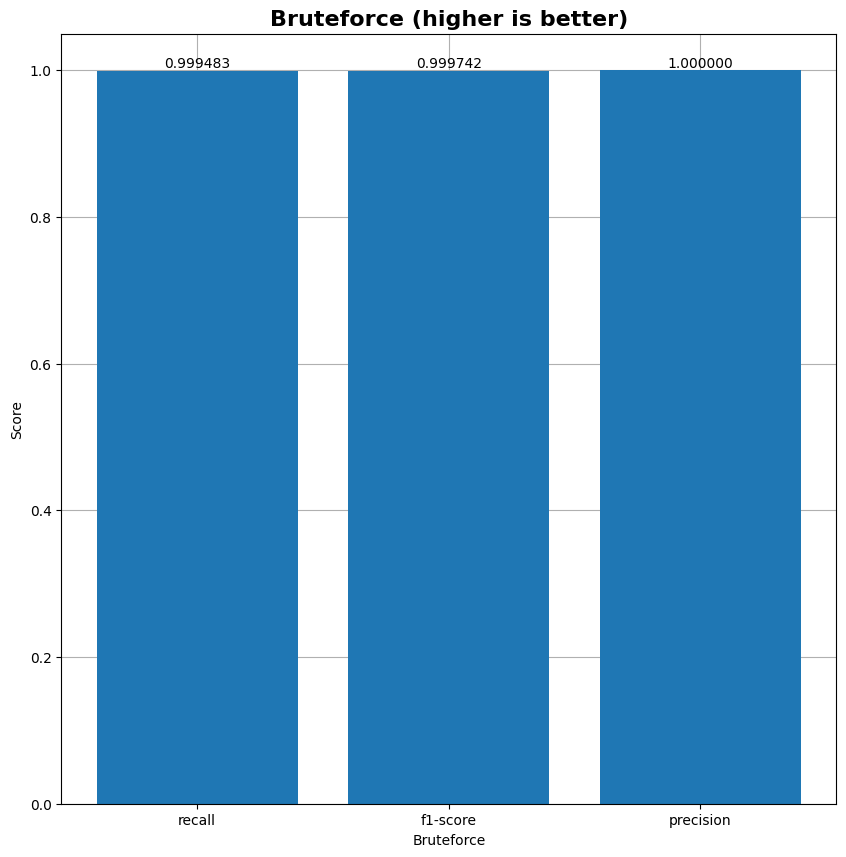

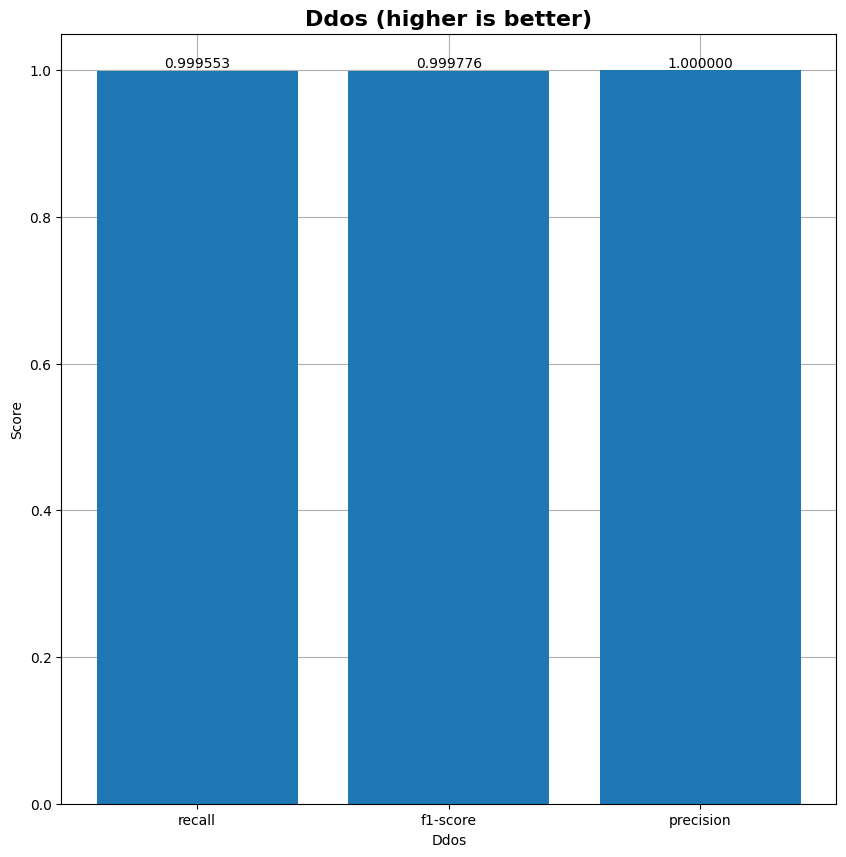

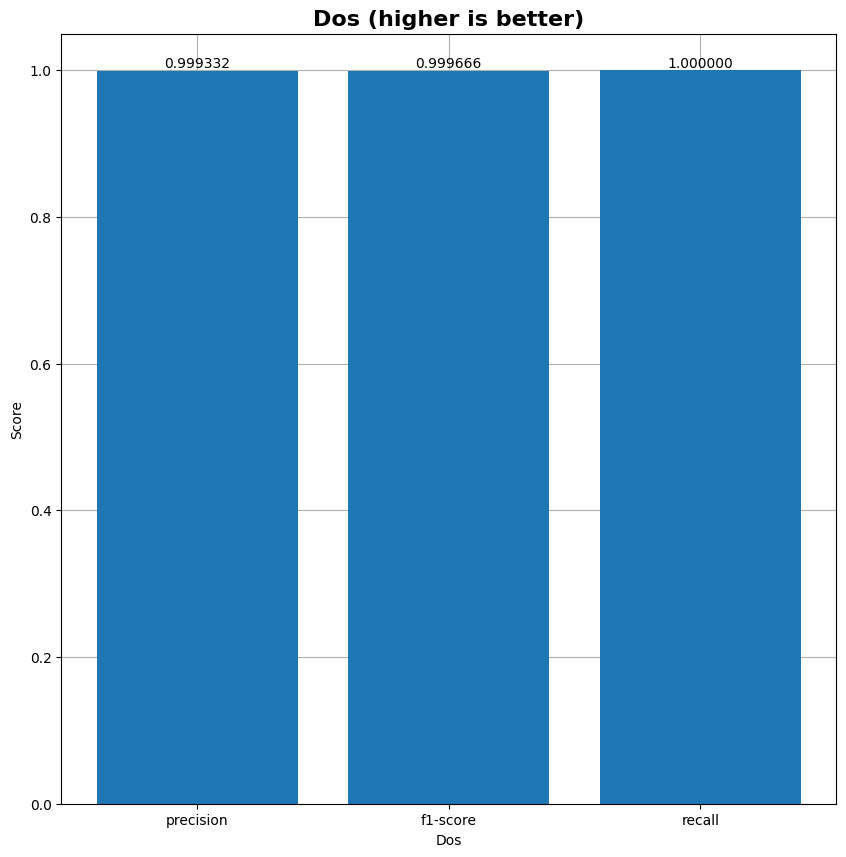

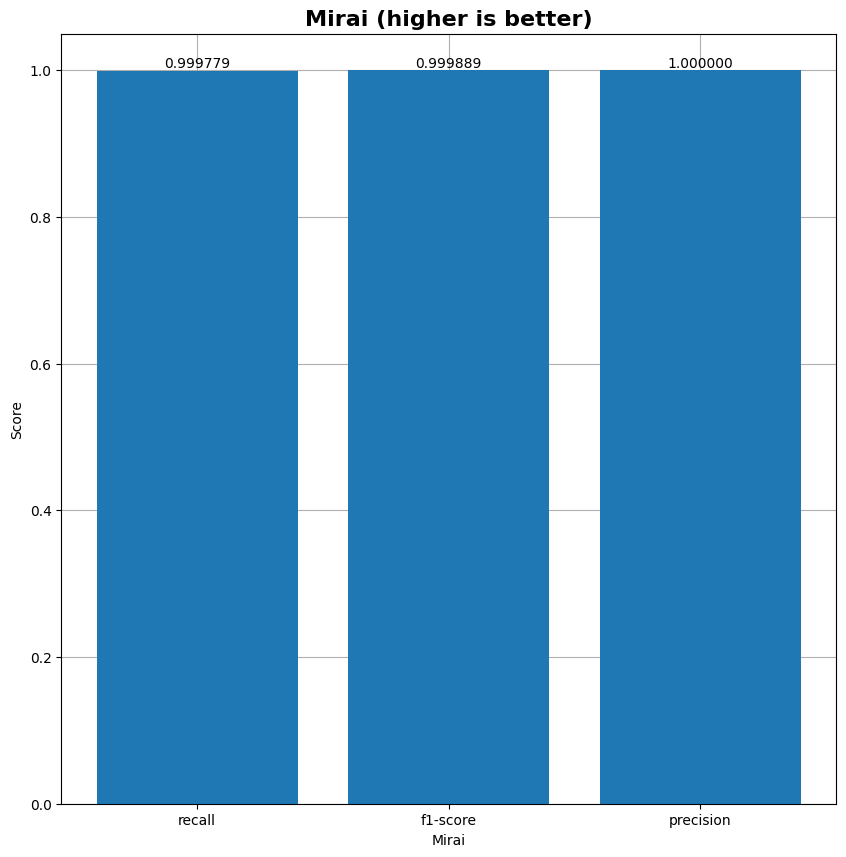

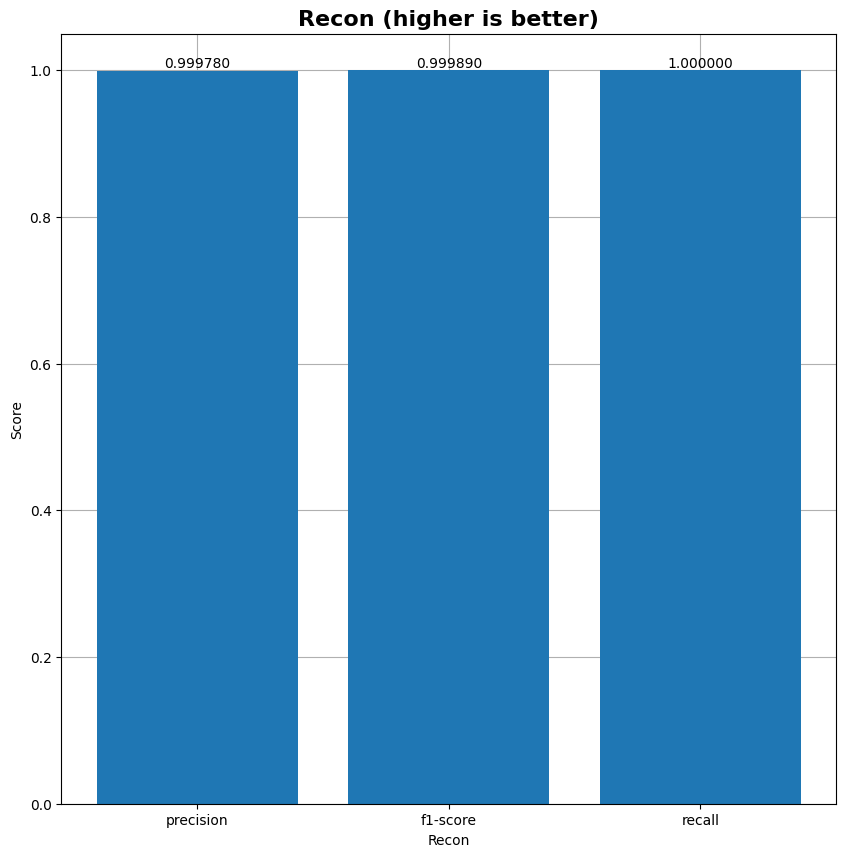

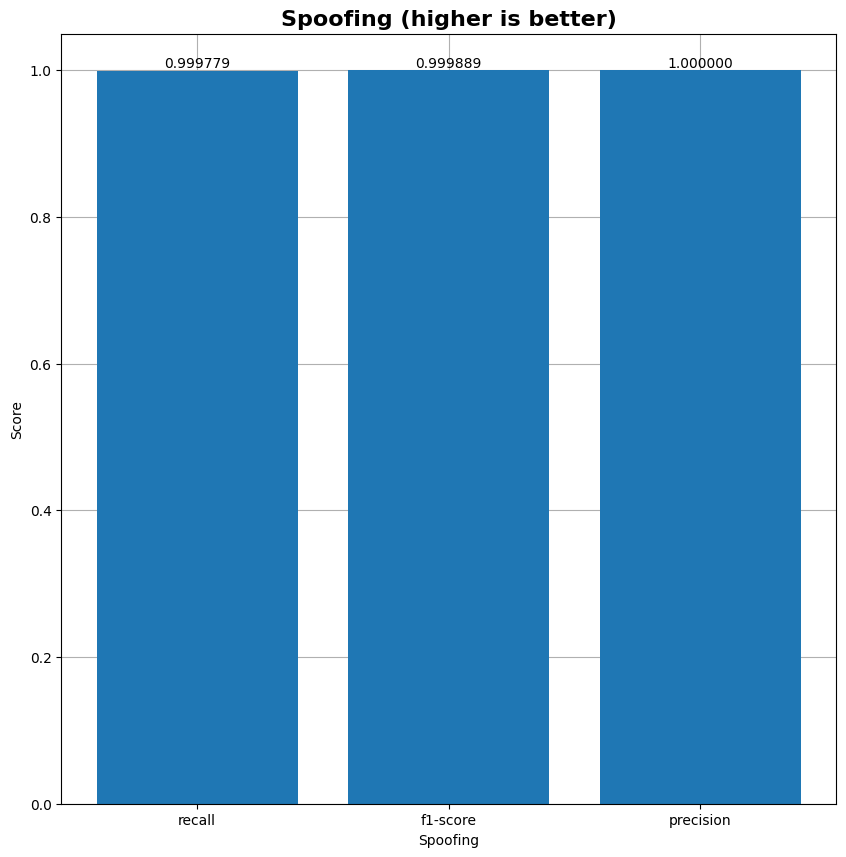

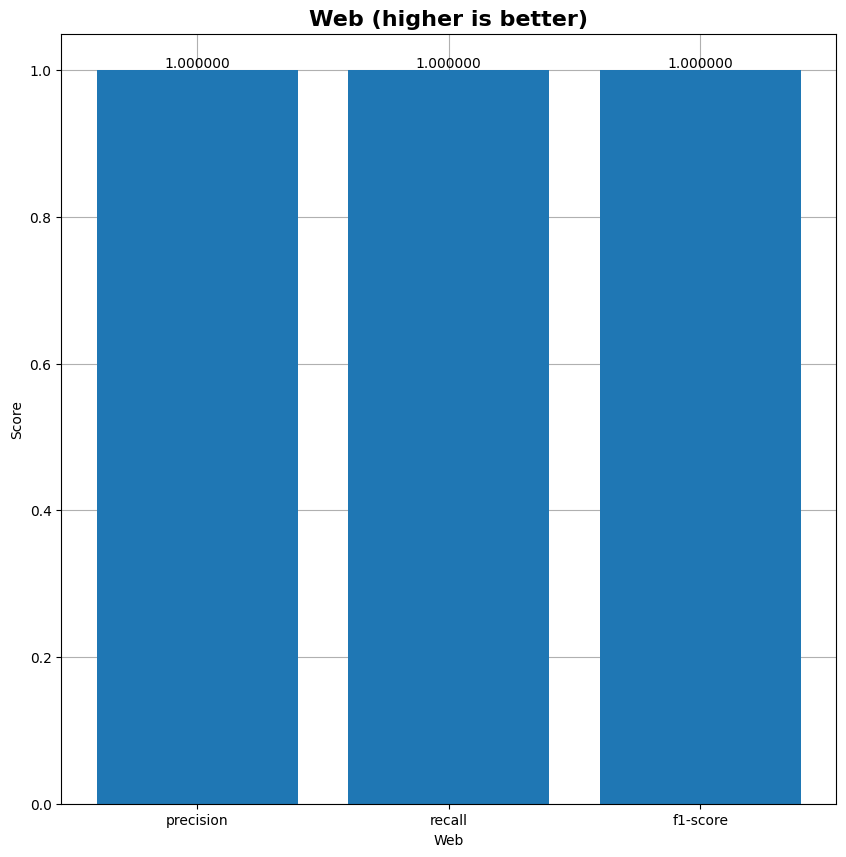

In [49]:
plot_mc(y_pred, y_test, "GRU")

In [50]:
model_name = "GRU_30000.sav"
pickle.dump(model, open(model_name, 'wb'))

# Plot data

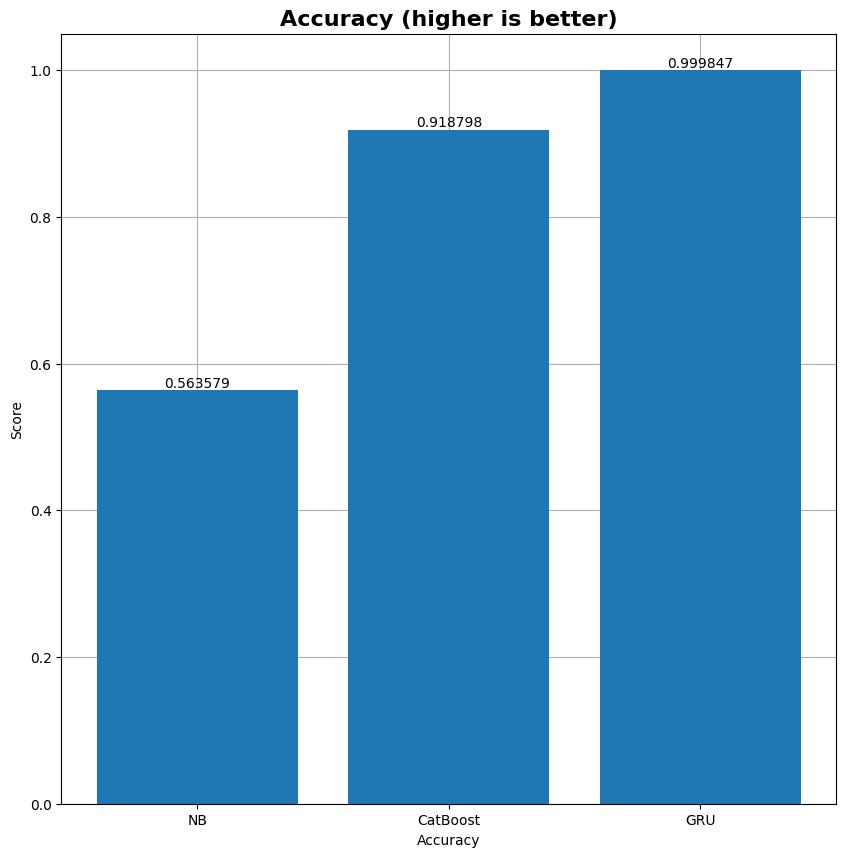

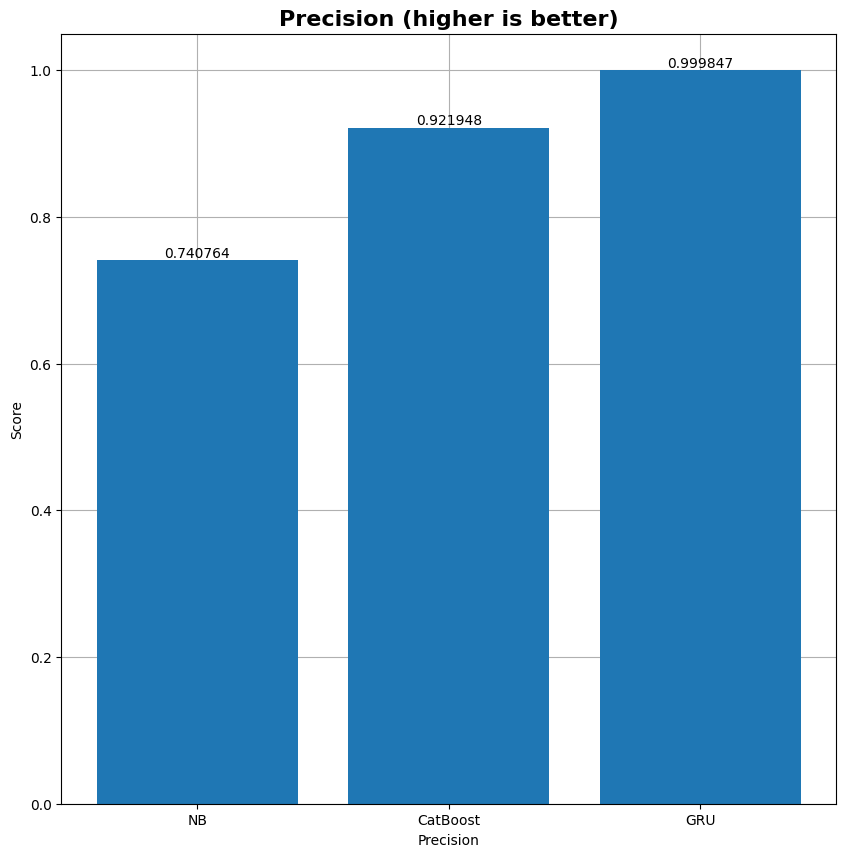

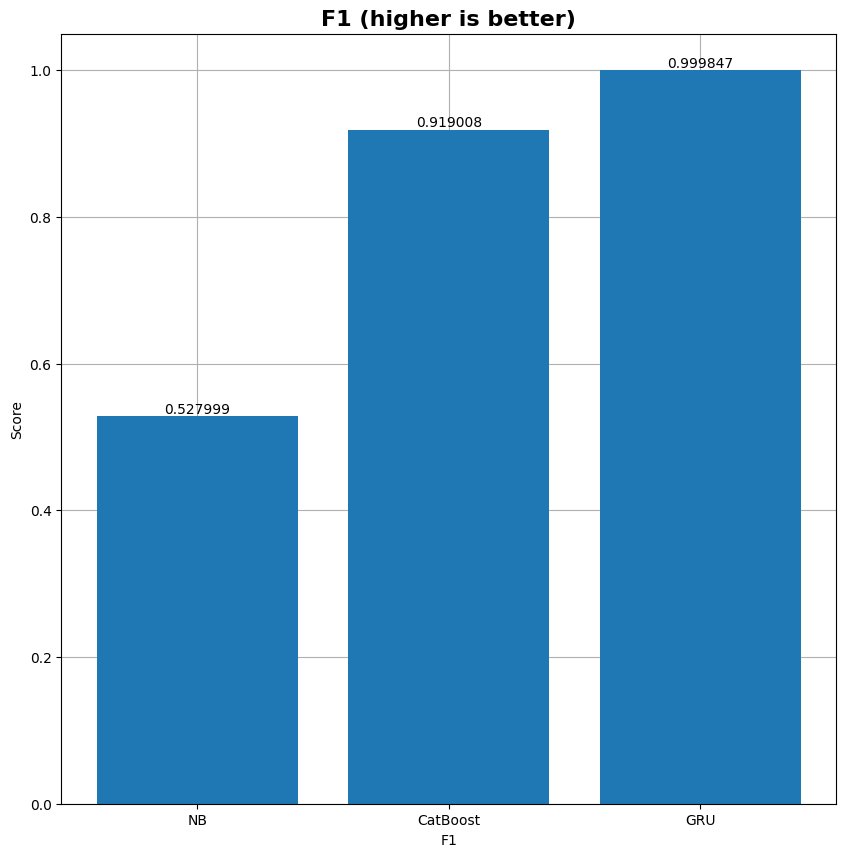

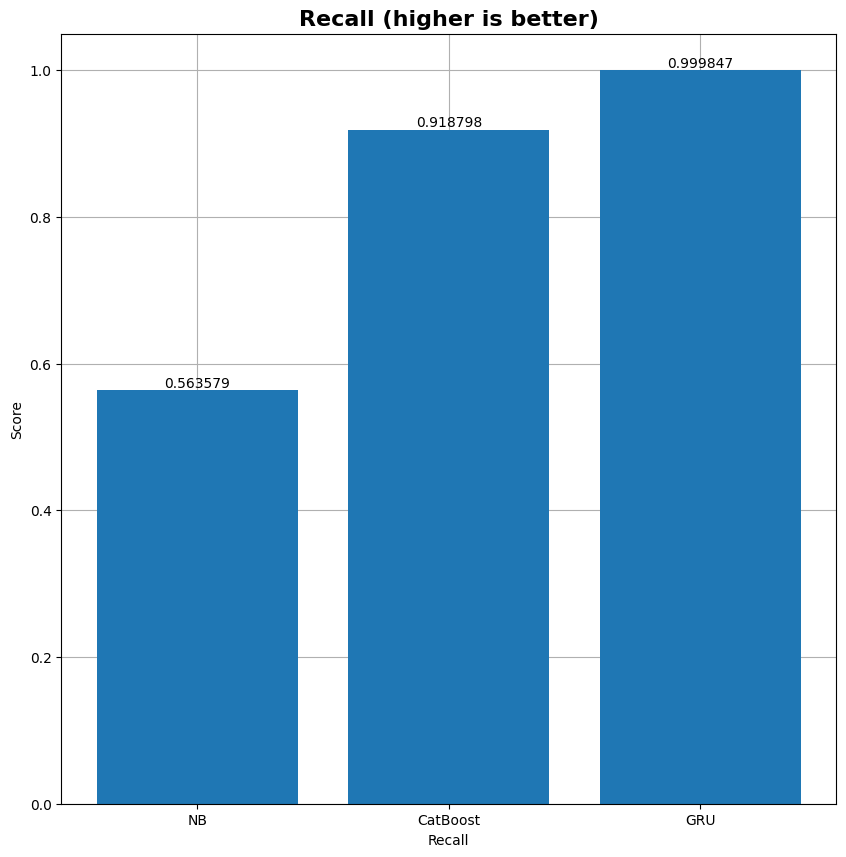

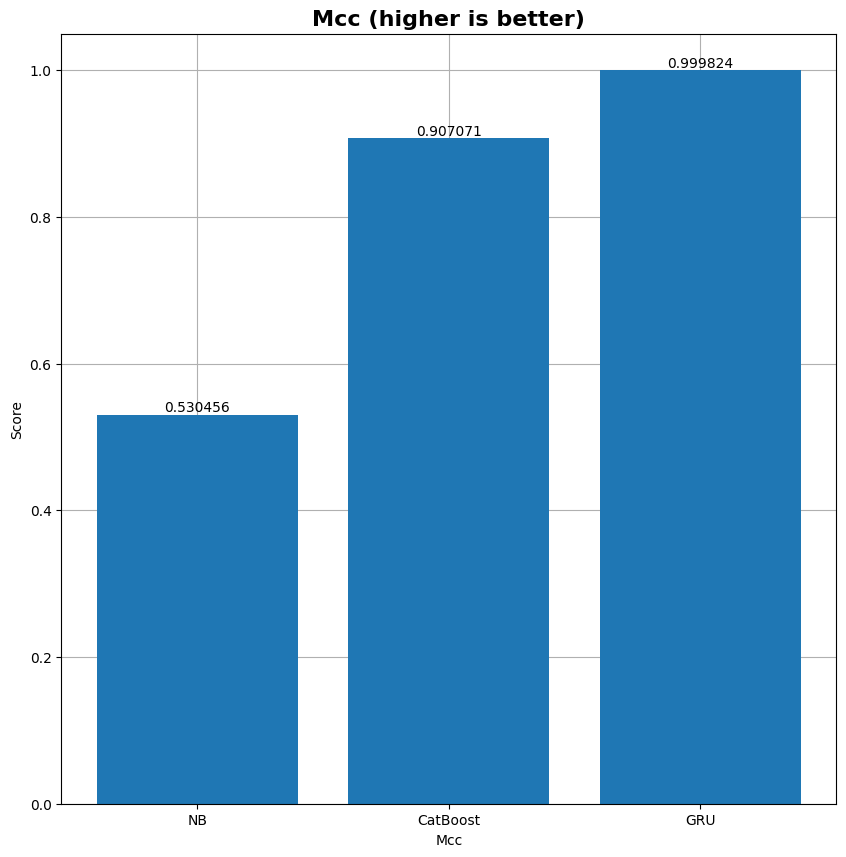

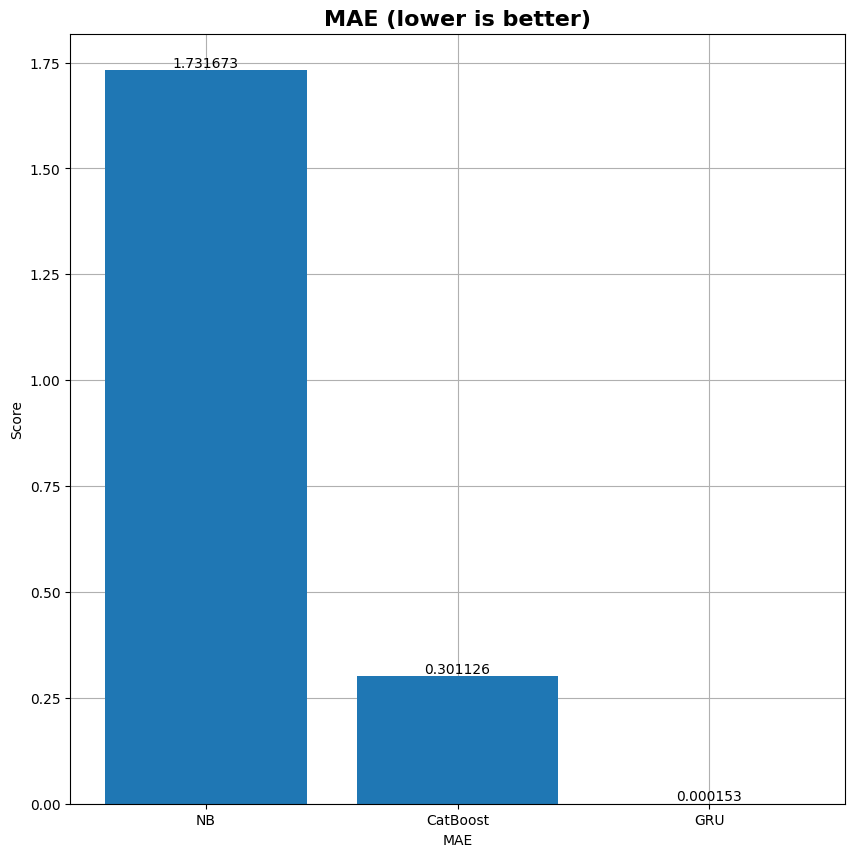

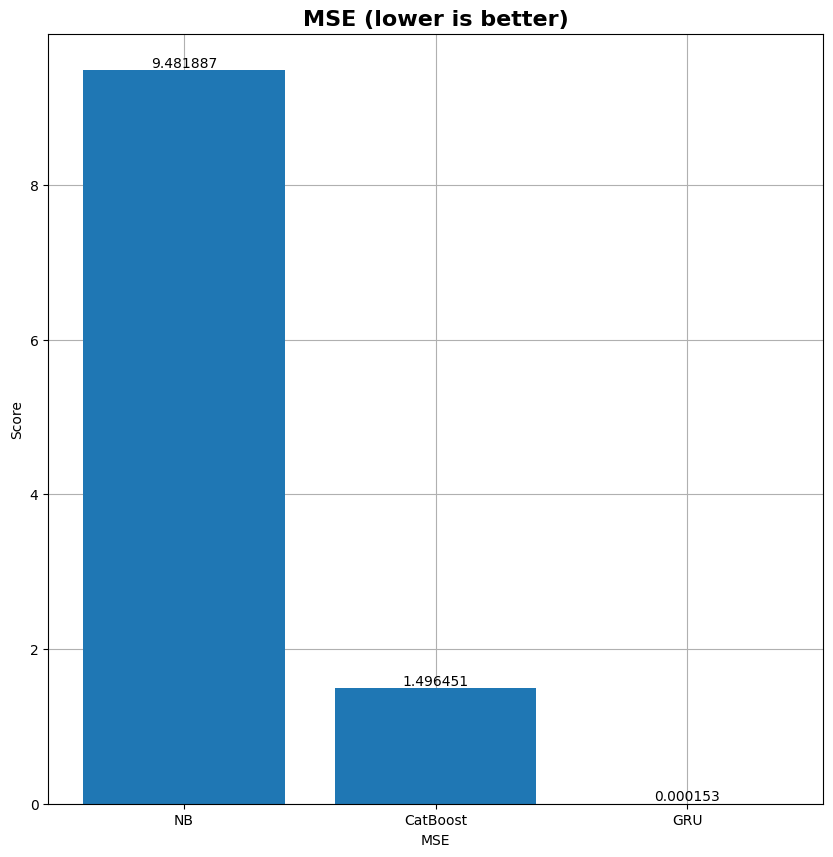

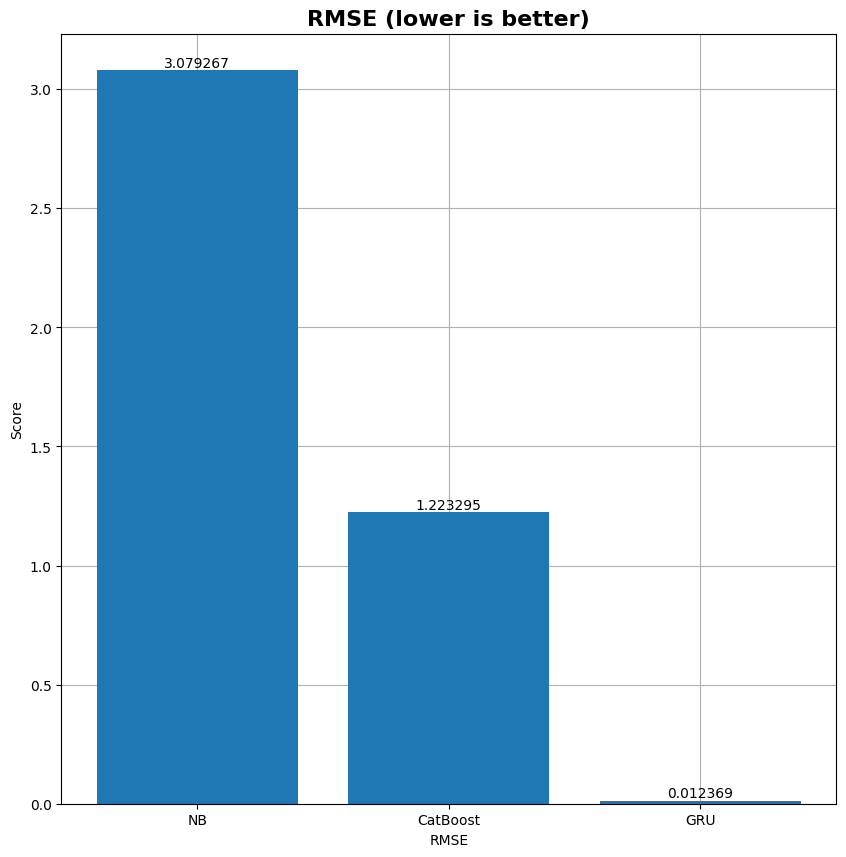

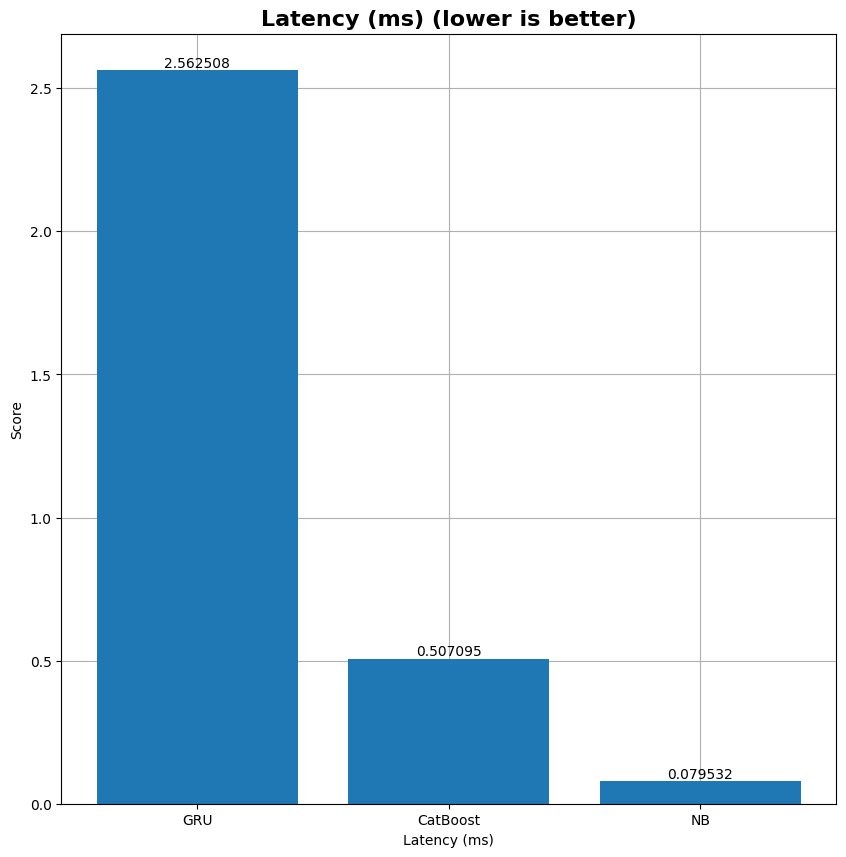

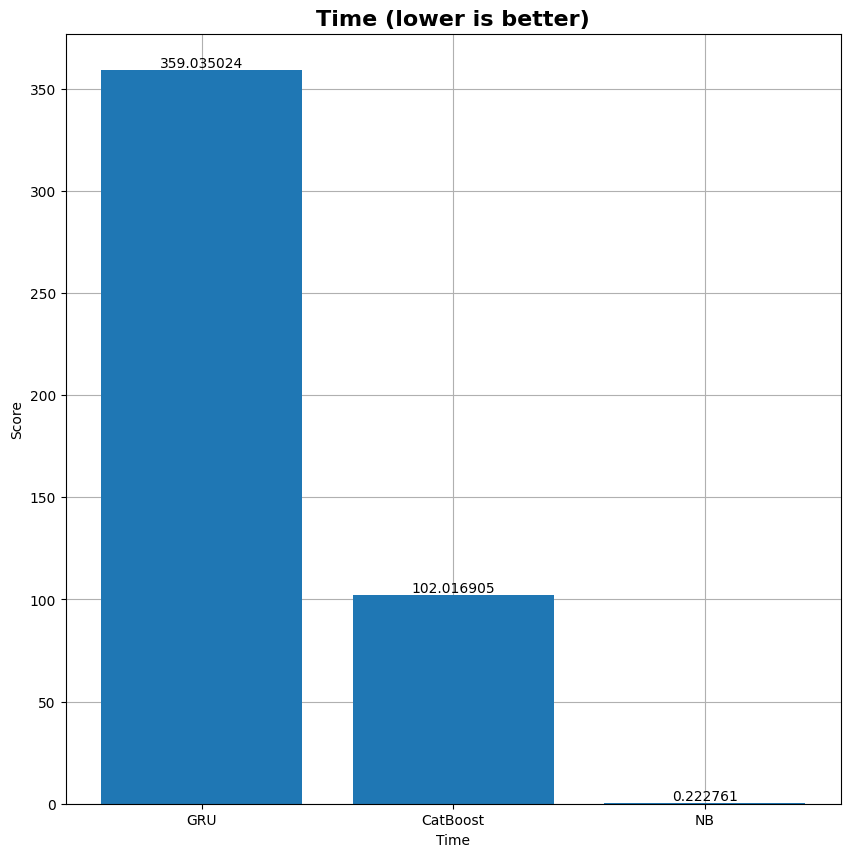

In [51]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Latency (ms)", "Time"])
for x in results_df:
    _dict = {}
    name = results_df[x].name
    for keys, values in zip(range(len(results_df[x].keys())), results_df[x]):
        _dict[results_df[x].keys()[keys]] = values
    result_plot(_dict, name, "multiclass", "")